In [2]:
import os
from os.path import join

import numpy as np
import matplotlib.pyplot as plt

import sys
plantbox_path = os.environ["PLANTBOX_PATH"]
sys.path.append(plantbox_path)
import plantbox as pb
from plantbox import RootSystem

In [3]:
param_dir = join(plantbox_path, "modelparameter", "rootsystem")
name = "Anagallis_femina_Leitner_2010"
param_path = join(param_dir,  f"{name}.xml")

## Root system length over time

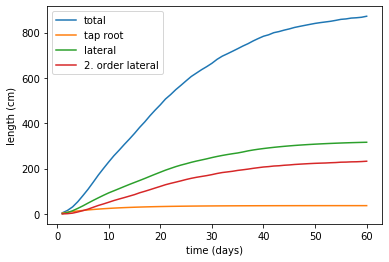

In [5]:
rs = pb.RootSystem()
rs.readParameters(param_path)
rs.initialize()

simtime = 60.  # days
dt = 1.
N = round(simtime / dt)  # steps

# Plot some scalar value over time
stype = "length"
v_, v1_, v2_, v3_ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
for i in range(N):
    rs.simulate(dt)
    t = np.array(rs.getParameter("type"))
    v = np.array(rs.getParameter(stype))
    v_[i] = np.sum(v)
    v1_[i] = np.sum(v[t == 1])
    v2_[i] = np.sum(v[t == 2])
    v3_[i] = np.sum(v[t == 3])

t_ = np.linspace(dt, N * dt, N)
plt.plot(t_, v_, t_, v1_, t_, v2_, t_, v3_)
plt.xlabel("time (days)")
plt.ylabel(stype + " (cm)")
plt.legend(["total", "tap root", "lateral", "2. order lateral"])
plt.show()

## Find root tips and bases

In [14]:
rs = RootSystem()
rs.readParameters(param_path)
rs.initialize()
rs.simulate(7)  # 7 days young....

In [15]:
print(rs.getNumberOfNodes(), "nodes")
print(rs.getNumberOfSegments(), "segments")

518 nodes
516 segments


In [18]:
# Use polyline representation of the roots
polylines = rs.getPolylines()
bases = np.zeros((len(polylines), 3))
tips = np.zeros((len(polylines), 3))
for i, r in enumerate(polylines):
    bases[i, :] = [r[0].x, r[0].y, r[0].z]
    tips[i, :] = [r[-1].x, r[-1].y, r[-1].z]

# Or, use node indices to find tip or base nodes
nodes = np.array((list(map(np.array, rs.getNodes()))))
tipI = rs.getRootTips()
baseI = rs.getRootBases()

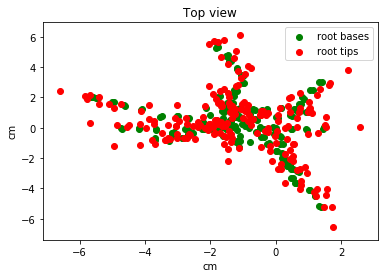

In [19]:
# Plot results (1st approach)
plt.title("Top view")
plt.xlabel("cm")
plt.ylabel("cm")
plt.scatter(nodes[baseI, 0], nodes[baseI, 1], c = "g", label = "root bases")
plt.scatter(nodes[tipI, 0], nodes[tipI, 1], c = "r", label = "root tips")
plt.legend()
plt.show()

 ## Root system surface density

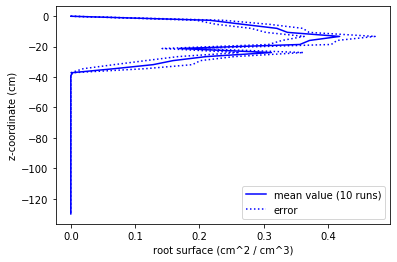

In [23]:
depth = 130
layers = 50
runs = 10

rl_ = []
for i in range(0, runs):
    rs.initialize(False)
    rs.simulate(120, False)
    ana = pb.SegmentAnalyser(rs)
    rl_.append(ana.distribution("length", 0., -depth, layers, True))

soilvolume = (depth / layers) * 10 * 10
rl_ = np.array(rl_) / soilvolume  # convert to density
rl_mean = np.mean(rl_, axis = 0)
rl_err = np.std(rl_, axis = 0) / np.sqrt(runs)

z_ = np.linspace(0, -depth, layers)  # z - axis
plt.plot(rl_mean, z_, "b")
plt.plot(rl_mean + rl_err, z_, "b:")
plt.plot(rl_mean - rl_err, z_, "b:")

plt.xlabel("root surface (cm^2 / cm^3)")
plt.ylabel("z-coordinate (cm)")
plt.legend(["mean value (" + str(runs) + " runs)", "error"])
plt.show()

## Analysis of results using signed distance functions

In [26]:
from cmath import pi

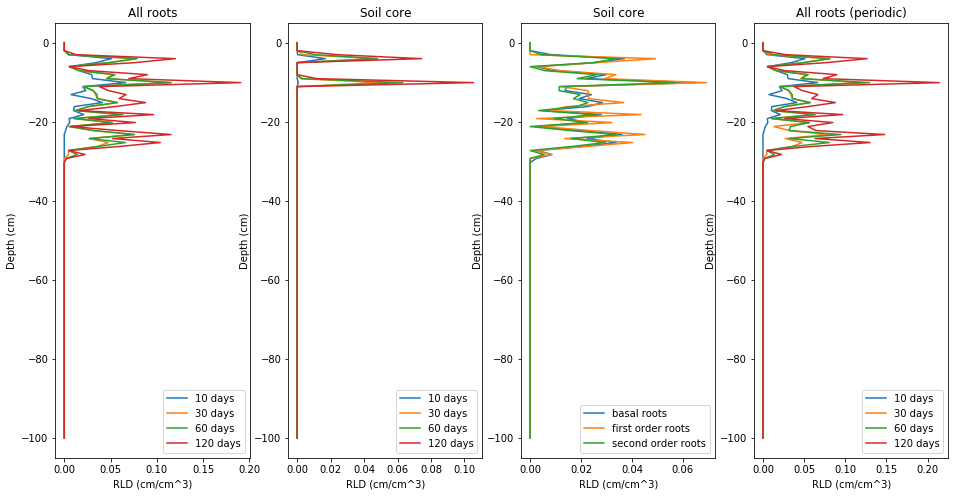

In [27]:
rs.initialize()
rs.simulate(120)

# Soil core analysis
r, depth, layers = 10, 100., 100

soilcolumn = pb.SDF_PlantContainer(r, r, depth, False)  # in the center of the root
soilcolumn2 = pb.SDF_RotateTranslate(soilcolumn, 0, 0, pb.Vector3d(12, 0, 0))  # shift 10 cm

# pick one geometry for further analysis
geom = soilcolumn2

z_ = np.linspace(0, -1 * depth, layers)
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 8))
for a in axes:
    a.set_xlabel('RLD (cm/cm^3)')  # layer size is 1 cm
    a.set_ylabel('Depth (cm)')

# Make a root length distribution
ana = pb.SegmentAnalyser(rs)
ana.cropDomain(20, 20, depth)
layerVolume = depth / layers * 20 * 20
rl0_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 60)
rl1_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 30)
rl2_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 10)
rl3_ = ana.distribution("length", 0., -depth, layers, True)
axes[0].set_title('All roots')
axes[0].plot(np.array(rl3_) / layerVolume, z_)
axes[0].plot(np.array(rl2_) / layerVolume, z_)
axes[0].plot(np.array(rl1_) / layerVolume, z_)
axes[0].plot(np.array(rl0_) / layerVolume, z_)
axes[0].legend(["10 days", "30 days", "60 days", "120 days"])

# Make a root length distribution along the soil core
layerVolume = depth / layers * r * r * pi
ana = pb.SegmentAnalyser(rs)
ana.crop(geom)
ana.pack()
rl0_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 60)
rl1_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 30)
rl2_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 10)
rl3_ = ana.distribution("length", 0., -depth, layers, True)
axes[1].set_title('Soil core')
axes[1].plot(np.array(rl3_) / layerVolume, z_)
axes[1].plot(np.array(rl2_) / layerVolume, z_)
axes[1].plot(np.array(rl1_) / layerVolume, z_)
axes[1].plot(np.array(rl0_) / layerVolume, z_)
axes[1].legend(["10 days", "30 days", "60 days", "120 days"])

# Only laterals
ana = pb.SegmentAnalyser(rs)
ana.cropDomain(20, 20, depth)
layerVolume = depth / layers * 20 * 20
ana.pack()
a = pb.SegmentAnalyser(ana)  # copy
a.filter("subType", 4)  # basal
rl4_ = a.distribution("length", 0., -depth, layers, True)
a = pb.SegmentAnalyser(ana)  # copy
a.filter("subType", 3)  # 2nd order
rl3_ = a.distribution("length", 0., -depth, layers, True)
a = pb.SegmentAnalyser(ana)  # copy
a.filter("subType", 2)  # 1st order
rl2_ = a.distribution("length", 0., -depth, layers, True)
a = pb.SegmentAnalyser(ana)  # copy
a.filter("subType", 1)  # tap
rl1_ = a.distribution("length", 0., -depth, layers, True)
axes[2].set_title('Soil core')
axes[2].plot((np.array(rl1_) + np.array(rl4_)) / layerVolume, z_)
axes[2].plot(np.array(rl2_) / layerVolume, z_)
axes[2].plot(np.array(rl3_) / layerVolume, z_)
axes[2].legend(["basal roots", "first order roots", "second order roots"])

# Make a root length distribution
ana = pb.SegmentAnalyser(rs)
ana.mapPeriodic(20, 20)
layerVolume = depth / layers * 20 * 20  # actually the only thing that changes
ana.write("results/example_3d_periodic.vtp")
rl0_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 60)
rl1_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 30)
rl2_ = ana.distribution("length", 0., -depth, layers, True)
ana.filter("creationTime", 0, 10)
rl3_ = ana.distribution("length", 0., -depth, layers, True)
axes[3].set_title('All roots (periodic)')
axes[3].plot(np.array(rl3_) / layerVolume, z_)
axes[3].plot(np.array(rl2_) / layerVolume, z_)
axes[3].plot(np.array(rl1_) / layerVolume, z_)
axes[3].plot(np.array(rl0_) / layerVolume, z_)
axes[3].legend(["10 days", "30 days", "60 days", "120 days"])

fig.subplots_adjust()

## analysis of nodes and segments from measurements

In [15]:
nodes = [ [0, 1, 0], [0, 1, -1], [0, 1, -2], [0, 1, -3], ]
segs = [ [0, 1], [1, 2], [2, 3] ]
cts = [0., 0., 0.]
radii = [ 0.1, 0.1, 0.1 ]

# convert from Python to C++ binding types
nodes = [pb.Vector3d(n[0], n[1], n[2]) for n in nodes]
segs = [pb.Vector2i(s[0], s[1]) for s in segs]

# create the SegmentAnalyser without underlying RootSystem
ana = pb.SegmentAnalyser(nodes, segs, cts, radii)

print("length", ana.getSummed("length"))
print("volume", ana.getSummed("volume"))

length 3.0
volume 0.0942477796076938


In [18]:
ana = pb.SegmentAnalyser(rs)
print("length", ana.getSummed("length"))
print("volume", ana.getSummed("volume"))

length 871.9857834150474
volume 1.8332018426177457


# everything from scratch (without parameter files)

In [31]:
import math

In [38]:
rs = pb.RootSystem()

# Root random parameter
p0 = pb.RootRandomParameter(rs)  # with default values,
p1 = pb.RootRandomParameter(rs)  # all standard deviations are 0

p0.name = "taproot"
p0.a = 0.2  # cm radius
p0.subType = 1
p0.lb = 1
p0.la = 10
hep0 = 20
p0.nobs

<bound method PyCapsule.nobs of <plantbox.RootRandomParameter object at 0x7fb5d0ee7148>>

In [41]:
# p0.nob
# p0.nobs = 20
p0.ln = 89. / 19.
p0.theta = 30. / 180.*math.pi
p0.r = 1  # initial growth rate
p0.dx = 0.5
p0.successor = [2]  # add successors
p0.successorP = [1]
p0.tropismT = pb.TropismType.gravi
p0.tropismN = 1.
p0.tropismS = 0.2

p1.name = "lateral"
p1.a = 0.1  # cm radius
p1.subType = 2
p1.la = 25
p1.las = 10  # add standard deviation
p1.ln = 0
p1.r = 2  # initial growth rate
p1.dx = 0.1
p1.tropismS = 0.3

rs.setOrganRandomParameter(p0)
rs.setOrganRandomParameter(p1)

# Seed random parameter (neglecting shoot borne)
srp = pb.SeedRandomParameter(rs)
srp.seedPos = pb.Vector3d(0., 0., -3.)
srp.maxB = 100
srp.firstB = 10.
srp.delayB = 3.
rs.setRootSystemParameter(srp)

rs.initialize(1, 1)  # basalType, shootborneType
rs.simulate(40)
# rs.write("../results/example_4a.vtp")

# Some output
print()
print("subType", rs.getParameter("subType"))
print("la", rs.getParameter("la"))
print("la_mean", rs.getParameter("la_mean"))
print("radius", rs.getParameter("radius"))
print()
print("length", rs.getParameter("length"))
print("age", rs.getParameter("age"))


subType [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
la [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
la_mean [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
radius [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

length [10.710172211041066, 10.280628564471538, 10.055075436583362, 9.758801939512374, 9.369634270287278, 8.858446208353389, 8.186979240955893, 7.304979206369214, 6.146435154640177, 4.624638933367096, 2.6256957463343893]
age [40.0, 30.0, 27.0, 24.0, 21.0, 18.0, 15.0, 12.0, 9.0, 6.0, 3.0]
